<a href="https://colab.research.google.com/github/nileshmalode11/petents_classification_and_sentance-similarity-project/blob/main/Copy_of_Dask_implimentation_22dec_with_streamlit_app.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# #Install sentence_transformers pandas torch
!pip install sentence_transformers
!pip install pyvis
!pip install transformers_interpret
# !pip install pyspark==3.5.0
!pip install torch
!pip install dask
!pip install polars

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 29.8 MB/s eta 0:00:00


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Import Required Libraries
import polars as pl
import pandas as pd
import numpy as np
import seaborn as sns
from sentence_transformers import SentenceTransformer, util
import os
import matplotlib.pyplot as plt
import networkx as nx
from jinja2 import Template
from pyvis.network import Network
from IPython.display import HTML

import torch
import dask.dataframe as dd
import dask.array as da

# from pyspark.sql.functions import count
# from pyspark.sql.functions import udf
# from pyspark.sql.types import ArrayType, FloatType
# from pyspark.sql.functions import col

from scipy.spatial.distance import cosine

In [ ]:
# Read JSON into Dask DataFrame
dask_df = dd.read_json("/content/drive/MyDrive/train/train/a/data000000000000.gz", lines=True)

In [ ]:
# Assuming df is your Dask DataFrame
concatenated_df = dask_df.assign(text=dask_df['abstract'].astype(str) + dask_df['description'])

In [ ]:
concatenated_df.head()

,publication_number,abstract,application_number,description,text
0,US-2006134160-A1,this invention relates to novel calcium phosph...,US-52740605-A,throughout the following description specific ...,this invention relates to novel calcium phosph...
1,US-4592498-A,"a stapler , particularly for suturing skin wou...",US-71138185-A,preferred embodiments of the invention are ill...,"a stapler , particularly for suturing skin wou..."
2,US-2014379009-A1,a nerve guidance conduit includes a spiral str...,US-201414313384-A,embodiments of the present invention provide n...,a nerve guidance conduit includes a spiral str...
3,US-4157173-A,a rail connector and improvement in seat base ...,US-86596677-A,"referring now to the drawings , and particular...",a rail connector and improvement in seat base ...
4,US-2017360443-A1,an anvil assembly is disclosed that includes a...,US-201715606289-A,exemplary embodiments of the presently disclos...,an anvil assembly is disclosed that includes a...


In [ ]:
%%time
#load the model
model = SentenceTransformer('AI-Growth-Lab/PatentSBERTa')

.gitattributes:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.88k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/671 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/440 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

CPU times: user 1.62 s, sys: 1.59 s, total: 3.21 s
Wall time: 7.75 s


In [ ]:
# concatenated_df1=concatenated_df["text"].compute().tolist()
# sentence_embeddings=model.encode(concatenated_df1)
# sentence_embeddings
# np.save("/content/drive/MyDrive/embeddings.npy",sentence_embeddings)

In [ ]:
sentence_embeddings=np.load("/content/drive/MyDrive/embeddings.npy")

In [ ]:
# #Load the sentence embeddigs
# sentence_embeddings=np.load("/content/drive/MyDrive/petants/sentence_embeddings49.npy")

In [ ]:
sample_text = concatenated_df['text'].sample(frac=1).compute().head(1).iloc[0]

In [ ]:
sample_text

'the protective device for a food bowl with a depression which is surrounded by an edge bead comprises a hold - down device with at least one adjustable hold - down element for holding a cover means in the form of a flexible sheet material within the depression , said hold - down element extending into the depression region . the cover means can additionally be held on the food bowl with a peripheral retaining device in the region of the edge bead . the cover means can be stored as a detachable section of a rolled - up band in a dispenser . the cover means comprises at least one receiving portion on the bottom side thereof for the at least one hold - down element .fig1 shows a plan view of a feeding bowl 1 with components of the protective device in a first embodiment . the feeding bowl 1 has a depression 5 surrounded by an edge bead 3 . the depression 5 is embedded within pairs of parallel - aligned straight edge bead segments 3 a , 3 b , 3 c , 3 d , which are connected by rounded cor

In [ ]:
%%time
query_embedding = model.encode([sample_text])

CPU times: user 1.28 s, sys: 5.16 ms, total: 1.29 s
Wall time: 1.28 s


In [ ]:
%%time
cosine_scores = util.pytorch_cos_sim(query_embedding, sentence_embeddings)[0]


CPU times: user 1.08 ms, sys: 1.02 ms, total: 2.1 ms
Wall time: 4.77 ms


In [ ]:
cosine_scores

tensor([0.5150, 0.5527, 0.4524,  ..., 0.5521, 0.3338, 0.4882])

In [ ]:
import dask.dataframe as dd
import dask.array as da

# Assuming concatenated_df is your concatenated Dask DataFrame
# Assuming cosine_scores is your NumPy array of similarity scores

# Convert the 'texts' column to Dask array
publication_number = concatenated_df['publication_number'].to_dask_array()
abstract = concatenated_df['abstract'].to_dask_array()
application_number = concatenated_df['application_number'].to_dask_array()
description = concatenated_df['description'].to_dask_array()

# Convert PyTorch tensor to NumPy array
cosine_scores_numpy = cosine_scores.detach().numpy()

# Convert NumPy array to Dask array
similarity_score = da.from_array(cosine_scores_numpy)

# Add the 'similarity_score' column to the existing Dask DataFrame
concatenated_df = concatenated_df.assign(similarity_score=similarity_score)

# Sort the Dask DataFrame by similarity scores in descending order
result_ddf = concatenated_df.sort_values(by='similarity_score', ascending=False)

# Now result_ddf is a Dask DataFrame with the added 'similarity_score'

In [ ]:
result_ddf.head()

,publication_number,abstract,application_number,description,text,similarity_score
380,US-2012285389-A1,the protective device for a food bowl with a d...,US-201013510952-A,fig1 shows a plan view of a feeding bowl 1 wit...,the protective device for a food bowl with a d...,1.000000
231,US-5454299-A,a food processor has a base and a bowl . the b...,US-23635494-A,fig1 shows a base 1 having the overall shape o...,a food processor has a base and a bowl . the b...,0.697362
29,US-5259503-A,a container of combustible material is provide...,US-96162492-A,"referring now to the drawings , wherein like o...",a container of combustible material is provide...,0.657002
850,US-5715772-A,an absorbent pad for animal accessories . the ...,US-51616495-A,"as required , detailed embodiments of the pres...",an absorbent pad for animal accessories . the ...,0.650332
474,US-2006071002-A1,medical tray and cover apparatus includes a tr...,US-20092205-A,"as required , detailed embodiments of the pres...",medical tray and cover apparatus includes a tr...,0.648712


In [ ]:
type(result_ddf)

dask.dataframe.core.DataFrame

In [ ]:
#took top 10 heighest mathes from result_ddf
final_df = result_ddf.nlargest(10, 'similarity_score').compute()
final_df

,publication_number,abstract,application_number,description,text,similarity_score
380,US-2012285389-A1,the protective device for a food bowl with a d...,US-201013510952-A,fig1 shows a plan view of a feeding bowl 1 wit...,the protective device for a food bowl with a d...,1.000000
231,US-5454299-A,a food processor has a base and a bowl . the b...,US-23635494-A,fig1 shows a base 1 having the overall shape o...,a food processor has a base and a bowl . the b...,0.697362
29,US-5259503-A,a container of combustible material is provide...,US-96162492-A,"referring now to the drawings , wherein like o...",a container of combustible material is provide...,0.657002
850,US-5715772-A,an absorbent pad for animal accessories . the ...,US-51616495-A,"as required , detailed embodiments of the pres...",an absorbent pad for animal accessories . the ...,0.650332
474,US-2006071002-A1,medical tray and cover apparatus includes a tr...,US-20092205-A,"as required , detailed embodiments of the pres...",medical tray and cover apparatus includes a tr...,0.648712
357,US-8066726-B2,a system for treatment of a vessel lesion comp...,US-99609904-A,while this invention may be embodied in many d...,a system for treatment of a vessel lesion comp...,0.648296
147,US-2011196339-A1,an injection device for administering a substa...,US-201113024970-A,"with regard to fastening , mounting , attachin...",an injection device for administering a substa...,0.638298
601,US-5921172-A,apparatus can cook foodstuffs with a pot and a...,US-3943398-A,"referring to fig1 and 2 , the present apparatu...",apparatus can cook foodstuffs with a pot and a...,0.635121
8,US-2007095961-A1,the present invention is aimed to provide a co...,US-26036305-A,"as shown in fig3 , the present invention is a ...",the present invention is aimed to provide a co...,0.635073
943,US-2013103058-A1,the invention relates to implantable medical d...,US-201113279101-A,one embodiment of a medical device according t...,the invention relates to implantable medical d...,0.634224


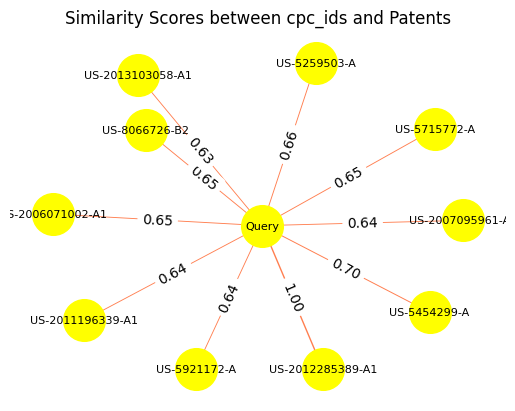

,publication_number,abstract,application_number,description,text,similarity_score
380,US-2012285389-A1,the protective device for a food bowl with a d...,US-201013510952-A,fig1 shows a plan view of a feeding bowl 1 wit...,the protective device for a food bowl with a d...,1.000000
231,US-5454299-A,a food processor has a base and a bowl . the b...,US-23635494-A,fig1 shows a base 1 having the overall shape o...,a food processor has a base and a bowl . the b...,0.697362
29,US-5259503-A,a container of combustible material is provide...,US-96162492-A,"referring now to the drawings , wherein like o...",a container of combustible material is provide...,0.657002
850,US-5715772-A,an absorbent pad for animal accessories . the ...,US-51616495-A,"as required , detailed embodiments of the pres...",an absorbent pad for animal accessories . the ...,0.650332
474,US-2006071002-A1,medical tray and cover apparatus includes a tr...,US-20092205-A,"as required , detailed embodiments of the pres...",medical tray and cover apparatus includes a tr...,0.648712
357,US-8066726-B2,a system for treatment of a vessel lesion comp...,US-99609904-A,while this invention may be embodied in many d...,a system for treatment of a vessel lesion comp...,0.648296
147,US-2011196339-A1,an injection device for administering a substa...,US-201113024970-A,"with regard to fastening , mounting , attachin...",an injection device for administering a substa...,0.638298
601,US-5921172-A,apparatus can cook foodstuffs with a pot and a...,US-3943398-A,"referring to fig1 and 2 , the present apparatu...",apparatus can cook foodstuffs with a pot and a...,0.635121
8,US-2007095961-A1,the present invention is aimed to provide a co...,US-26036305-A,"as shown in fig3 , the present invention is a ...",the present invention is aimed to provide a co...,0.635073
943,US-2013103058-A1,the invention relates to implantable medical d...,US-201113279101-A,one embodiment of a medical device according t...,the invention relates to implantable medical d...,0.634224


In [ ]:
# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges based on similarity scores
for i in range(len(final_df)):
    pub_num = final_df.iloc[i]['publication_number']
    app_num = final_df.iloc[i]['application_number']
    similarity_score = final_df.iloc[i]['similarity_score']
    sentence = final_df.iloc[i]['text']

    G.add_node(pub_num, label=f"pub_num {pub_num}\napp_num {app_num}\nSimilarity {similarity_score:.4f}")

    # # Connect nodes with directed edges based on similarity score
    G.add_edge("Query",pub_num, weight=similarity_score)

# Draw the graph using a force-directed layout
pos = nx.spring_layout(G)

# Extract edge weights for visualization
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]

# Draw nodes, edges, and labels
nx.draw_networkx_nodes(G, pos, node_size=900, node_color="yellow")
nx.draw_networkx_edges(G, pos, width=edge_weights, edge_color="coral", alpha=1)
nx.draw_networkx_labels(G, pos, font_size=8, font_color="black")

# Display edge weights on the graph
edge_labels = {(u, v): f"{G[u][v]['weight']:.2f}" for u, v in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)



# Show the graph
plt.title("Similarity Scores between cpc_ids and Patents")
plt.axis("off")
plt.show()
final_df

In [ ]:
import networkx as nx
from pyvis.network import Network
from IPython.display import HTML

# Extracting necessary columns for visualization
data = final_df[['publication_number', 'application_number', 'similarity_score']]

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges based on similarity scores
for i in range(len(data)):
    pub_num = str(data.iloc[i]['publication_number'])  # Convert to string if not already
    app_num = str(data.iloc[i]['application_number'])  # Convert to string if not already
    similarity_score = float(data.iloc[i]['similarity_score'])  # Convert to float

    G.add_node(app_num, label=f"Pub_num {pub_num}\nSimilarity {similarity_score:.4f}")
    G.add_edge("Query", app_num, value=similarity_score)

# Create a Pyvis network
pyvis_network = Network(notebook=True, cdn_resources='remote')
pyvis_network.from_nx(G)

# Save the Pyvis network as an HTML file
html_file_path = '/content/drive/MyDrive/model.html'
pyvis_network.save_graph(html_file_path)

# Display the web diagram in Colab
with open(html_file_path, 'r') as file:
    html_content = file.read()

HTML(html_content)


## **streamlit app**


In [2]:
! pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 49.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 10.1 MB/s eta 0:00:00
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 7.0.0
    Uninstalling importlib-metadata-7.0.0:
      Successfully uninstalled importlib-metadata-7.0.0


In [3]:
pip install streamlit pandas sentence_transformers dask


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.8 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=3f325e20346edcd9c82f702ba8fdd1d580f0a5181f02682794918c01a0ef1fc5
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers


In [5]:
%%writefile app0.py
import streamlit as st
import pandas as pd
from sentence_transformers import SentenceTransformer, util
import dask.array as da
import dask.dataframe as dd
import numpy as np

st.title('Similarity Score Detection System')

st.markdown(
    """
    Enter a sentence for similarity comparison:
    """
)

query = st.text_area('Enter a sentence for similarity comparison:')
model = SentenceTransformer('AI-Growth-Lab/PatentSBERTa')

submitted = st.button('Submit')

if submitted:
    # Assuming concatenated_df is your Dask DataFrame
    # Assuming sentence_embeddings is your Dask array of sentence embeddings

    # Encode the query
    query_embedding = model.encode([query])[0]  # Ensure to access the first element of the list

    # Assuming concatenated_df is your Dask DataFrame
    # Assuming sentence_embeddings is your Dask array of sentence embeddings


    concatenated_df = dd.read_json("/content/drive/MyDrive/data000000000000.json", lines=True)


    sentence_embeddings = np.load("/content/drive/MyDrive/petants/sentence_embeddings49.npy")

    # Calculate cosine similarity scores
    cosine_scores = util.pytorch_cos_sim(query_embedding, sentence_embeddings)[0]

    # Convert PyTorch tensor to NumPy array
    cosine_scores_numpy = cosine_scores.detach().numpy()

    # Convert NumPy array to Dask array
    similarity_score = da.from_array(cosine_scores_numpy)

    # Add the 'similarity_score' column to the existing Dask DataFrame
    concatenated_df = concatenated_df.assign(similarity_score=similarity_score)

    # Sort the Pandas DataFrame by similarity scores in descending order
    result_df = concatenated_df.compute().sort_values(by='similarity_score', ascending=False)

    # Now result_df is a Pandas DataFrame with the added 'similarity_score'
    st.write(result_df)


Overwriting app0.py


In [6]:
!streamlit run app0.py & npx localtunnel --port 8501

[##................] / fetchMetadata: sill resolveWithNewModule ms@2.1.2 checki

npx: installed 22 in 2.921s
your url is: https://sad-moments-rhyme.loca.lt

  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://35.222.133.150:8501

  Stopping...
^C


**Initial steps using dask**
1. load dataset
2. load the model
3. load sentence embendding
4. query embeding by the model
5. finding similarity score in dataset for query sentence
**Streamlit App Running steps**

1. Install streamlit ->> ! pip install streamlit
2. Install  sentence_transformers dask ->> pip install streamlit pandas sentence_transformers dask
3. build app.py file wich is in above cell
4. Run the app.py file at respected port ->> !streamlit run app0.py & npx localtunnel --port 8501
5. After runnig app.py enter external ip adress in our case ->> 35.222.133.150